# Convolutional Neural Network for Galaxy Morphological Classification

### Import and Set Up

We import all the necessary libraries for data manipulation, visualization, and deep learning. These will be used to build and train our Convolutional Neural Network (CNN) for galaxy classification.

In [ ]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
from scipy.ndimage import rotate

# Progress bar
from tqdm import tqdm

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Load the Data

We load the dataset containing galaxies with spectroscopic data

In [2]:
train = pd.read_csv("./Galaxies_Spectra.csv")

### Define Labels and Threshold

Here, we specify the columns representing class probabilities and their corresponding labels. We also define a threshold to determine which class is assigned.

In [3]:
# Columns containing classification probabilities
prob_cols = ['P_CW', 'P_ACW', 'P_EL', 'P_EDGE', 'P_DK', 'P_MG', 'P_CS']

# Corresponding labels
labels = ['SPIRAL_CW', 'SPIRAL_ACW', 'ELLIPTICAL', 'EDGE', 'DISK', 'MERGER', 'COSMOLOGICAL_STRUCTURE']

# Minimum probability required to assign a label
threshold = 0.5

### Assign Labels Based on Probabilities

We assign each galaxy a label based on the highest probability that exceeds the threshold. If no class meets the threshold, the label is set to "UNCERTAIN".

In [4]:
# Extract probability values
probs = train[prob_cols].values

# Find max probability and corresponding class index for each row
max_probs = probs.max(axis=1)
max_indices = probs.argmax(axis=1)

# Assign label if max probability >= threshold, otherwise 'UNCERTAIN'
assigned_labels = np.where(
    max_probs >= threshold,
    np.array(labels)[max_indices],
    'UNCERTAIN'
)

# Add the labels to the dataframe
train['Assigned_Label'] = assigned_labels

# Display examples
print(train[['Assigned_Label'] + prob_cols].head())

  Assigned_Label   P_CW  P_ACW   P_EL  P_EDGE   P_DK   P_MG   P_CS
0     ELLIPTICAL  0.034  0.000  0.610   0.153  0.153  0.051  0.186
1     ELLIPTICAL  0.000  0.167  0.611   0.222  0.000  0.000  0.389
2     ELLIPTICAL  0.029  0.000  0.735   0.147  0.074  0.015  0.176
3     ELLIPTICAL  0.019  0.000  0.885   0.058  0.019  0.019  0.077
4     ELLIPTICAL  0.000  0.000  0.712   0.220  0.068  0.000  0.220


### Visualize the Distribution of Assigned Classes

We visualize the number of galaxies assigned to each class, which gives us an idea of class imbalance or uncertainty.

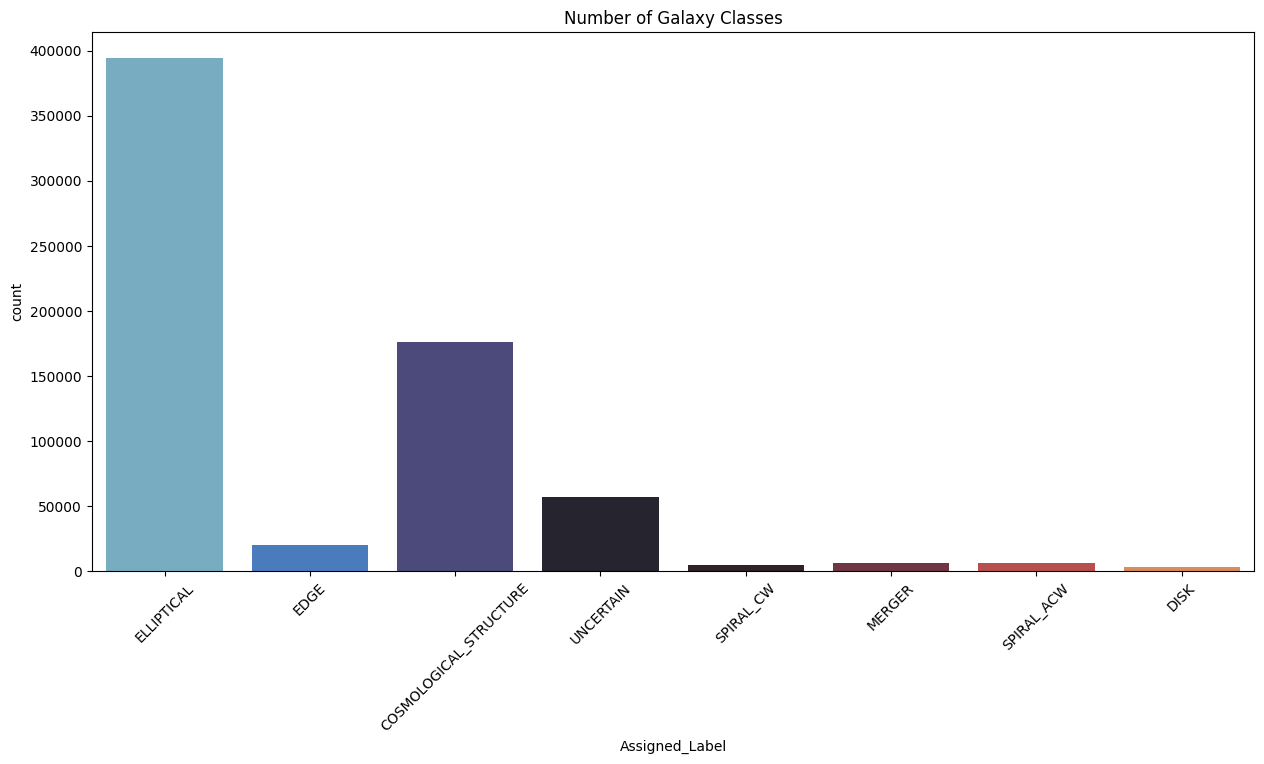

In [5]:
# Plot the count of each assigned label
plt.figure(figsize=(15, 7))
sns.countplot(data=train, x='Assigned_Label', hue='Assigned_Label', palette='icefire', legend=False)
plt.title("Number of Galaxy Classes")
plt.xticks(rotation=45)
plt.show()

### Define Paths for Spectra Matrices

Here, we specify the directories where the spectral matrix files for each galaxy are stored.

In [6]:
train_matrix_dir = "./Spectra_matrices/Spectra_matrices"

### Load Mapping Between Filenames and Galaxy IDs

This CSV contains the mapping between matrix filenames and galaxy IDs, which is needed to align the matrix data with the labels.

In [7]:
mapping_file = "./gz2_filename_mapping.csv"
mapping_df = pd.read_csv(mapping_file)

### Balance and Sample the Dataset

To ensure balanced training data, we sample 15,000 galaxies from each class. This helps the model learn more equally across all morphological types.

In [8]:
np.random.seed(42)

# Sample 15,000 examples from each class (with replacement if not enough samples)
train = train.groupby('Assigned_Label').apply(
    lambda x: x.sample(n=15000, replace=len(x) < 15000)
).reset_index(drop=True)

print(train['Assigned_Label'].value_counts()) 

Assigned_Label
COSMOLOGICAL_STRUCTURE    15000
DISK                      15000
EDGE                      15000
ELLIPTICAL                15000
MERGER                    15000
SPIRAL_ACW                15000
SPIRAL_CW                 15000
UNCERTAIN                 15000
Name: count, dtype: int64


/tmp/ipykernel_2082/1733161426.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('Assigned_Label').apply(


### Merge Spectra Matrix Mapping

We merge the galaxy dataset with the matrix ID mapping file to link each galaxy to its corresponding .npy matrix file.

In [9]:
train_df = pd.merge(train, mapping_df, left_on='OBJID', right_on='objid')

### Load Matrix Data and Labels

This section reads each galaxy's spectral matrix and its label. These matrices are stored in .npy files and represent the input to our CNN.

In [10]:
rib_data = []  # List to store matrix data
labels = []    # List to store labels

# Iterate through each galaxy and load its matrix
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    asset_id = row['asset_id']
    rib_path = os.path.join(train_matrix_dir, f"{asset_id}.npy")
    
    if os.path.exists(rib_path):
        rib_matrix = np.load(rib_path)
        rib_data.append(rib_matrix)
        labels.append(row['Assigned_Label'])

100%|██████████| 52505/52505 [00:20<00:00, 2515.47it/s]


### Preprocess the Input and Labels

Once we have the data and labels, we convert them to NumPy arrays and encode the labels into one-hot format for training.

In [11]:
# Convert list of matrices to numpy array
X = np.array(rib_data)

# Convert labels to numpy array
y = np.array(labels)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the encoded labels
y_one_hot = to_categorical(y_encoded)

### Train-Test Split

We split the dataset into training and validation subsets using stratified sampling to preserve class balance.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, stratify=y_one_hot, random_state=42)

### Define the CNN Model

This cell defines our Convolutional Neural Network (CNN) model using the Keras Sequential API. The architecture consists of three convolutional blocks with increasing filter sizes (32, 64, 128).

Each block contains two convolutional layers with ReLU activation and batch normalization, followed by max pooling and dropout for regularization.

After feature extraction, a global average pooling layer reduces the spatial dimensions before passing data to a dense layer with 256 neurons. A final softmax layer outputs class probabilities for 8 classes.


In [13]:
model = Sequential([
    Input(shape=X_train.shape[1:]),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Classifier
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

I0000 00:00:1750005824.121705    2082 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10274 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:87:00.0, compute capability: 8.6
I0000 00:00:1750005824.123836    2082 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10274 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:88:00.0, compute capability: 8.6


### Compile the CNN Model

This cell compiles the CNN model with the Adam optimizer (learning rate = 0.001), using categorical crossentropy as the loss function and accuracy as the evaluation metric.

Additionally, two callbacks are defined to improve training:

EarlyStopping stops training if validation performance stops improving for 10 epochs and restores the best model weights, while ReduceLROnPlateau reduces the learning rate by a factor of 0.5 if the validation metric stops changing significantly for 5 epochs.


In [14]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

### Train the Model

We now train the model for 100 epochs using the training data. Validation data is used to monitor generalization performance.

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


I0000 00:00:1750005858.391506    2300 service.cc:152] XLA service 0x7f965801b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750005858.392432    2300 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1750005858.392821    2300 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1750005859.343480    2300 cuda_dnn.cc:529] Loaded cuDNN version 90800


   3/1276 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.2882 - loss: 2.2390   

I0000 00:00:1750005873.585632    2300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 98s 56ms/step - accuracy: 0.3467 - loss: 1.6211 - val_accuracy: 0.3624 - val_loss: 1.6829 - learning_rate: 0.0010
Epoch 2/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.5181 - loss: 1.1538 - val_accuracy: 0.6867 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 3/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.7345 - loss: 0.7522 - val_accuracy: 0.7326 - val_loss: 0.7390 - learning_rate: 0.0010
Epoch 4/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.7686 - loss: 0.6519 - val_accuracy: 0.8024 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 5/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.7824 - loss: 0.6060 - val_accuracy: 0.7353 - val_loss: 0.7547 - learning_rate: 0.0010
Epoch 6/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.7960 - loss: 0.5682 - val_accuracy: 0.8104 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 7/100
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0

### Evaluate the Model

Once training is complete, we evaluate the model’s performance on the validation dataset.


In [16]:
# Evaluate accuracy and loss on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8625 - loss: 0.4080
Validation Loss: 0.4053
Validation Accuracy: 0.8617


### Plot Training and Validation History

We visualize how training and validation accuracy/loss evolve over time to assess learning behavior.

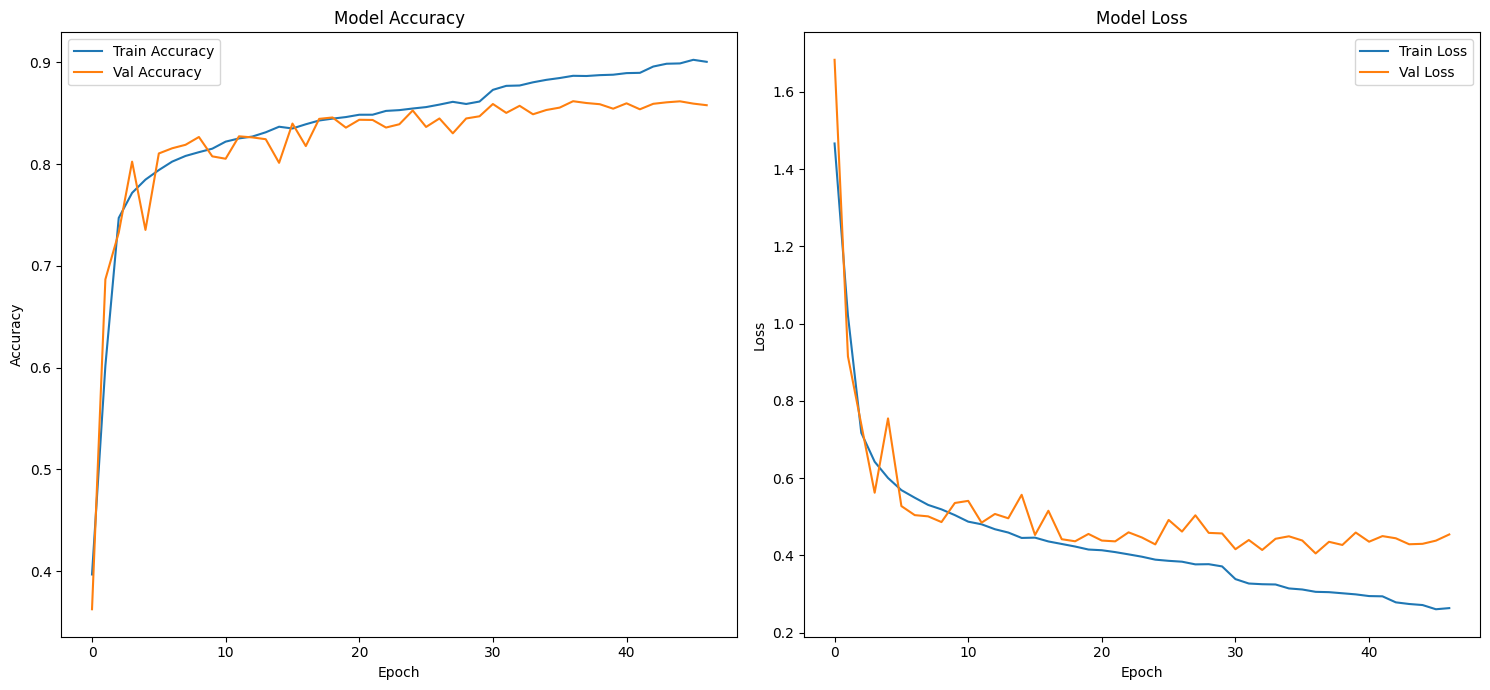

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(15, 7))

# Accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Function to apply random transformations

For each image, the function randomly picks one of four rotations (0°, 90°, 180°, 270°). 

In [21]:
def random_transform(matrix):
    k = random.choice([0, 1, 2, 3])  # 0°, 90°, 180°, 270°
    transformed = np.rot90(matrix, k=k)
    return transformed

### Evaluating Model Robustness to Rotations

To assess the model’s robustness, we create a test set by applying _random_transform_ to the original images. 
We then evaluate the CNN's performance on this rotated test set.

The goal is to demonstrate that the CNN 
maintains strong performance despite the transformations, indicating that it has learned rotation-invariant features.


In [22]:
# Apply transformation to the entire validation set
X_test_augmented = np.array([random_transform(matrix) for matrix in X_val])

# Predict on the augmented test set
y_test_pred = model.predict(X_test_augmented)

# Convert predictions and true labels from one-hot to class indices
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_val, axis=1)

# Calculate accuracy
matches = np.sum(y_test_pred_labels == y_test_true_labels)
percentage_matches = (matches / len(y_test_true_labels)) * 100

print(f"Percentage of test set matches (after augmentation): {percentage_matches:.2f}%")

319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Percentage of test set matches (after augmentation): 83.29%


### Evaluating Model Performance on the Validation Set

To assess the model’s performance, we evaluate it on the validation set using detailed per-class metrics.

This includes precision, recall, F1 score, accuracy, and AUC for each morphological class. The model’s predicted probabilities are compared against the true one-hot encoded labels to compute class-wise and macro-averaged performance.

In [25]:
y_true = np.argmax(y_val, axis=1)
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names from LabelEncoder
class_names = label_encoder.classes_

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Per-class precision, recall, and F1
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(len(class_names))
)

# Per-class accuracy from confusion matrix
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# AUC
try:
    auc_macro = roc_auc_score(y_val, y_pred_probs, average='macro', multi_class='ovr')
    auc_per_class = roc_auc_score(y_val, y_pred_probs, average=None, multi_class='ovr')
except ValueError:
    auc_macro = None
    auc_per_class = [None] * len(class_names)

# Summary table
summary_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Accuracy': per_class_accuracy,
    'AUC': auc_per_class
})

# Average metrics
summary_df.loc['Average'] = [
    'Average',
    precision.mean(),
    recall.mean(),
    f1.mean(),
    per_class_accuracy.mean(),
    auc_macro
]

display(summary_df)

319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


,Class,Precision,Recall,F1,Accuracy,AUC
0,COSMOLOGICAL_STRUCTURE,0.676883,0.550178,0.606989,0.550178,0.901202
1,DISK,0.944681,0.977974,0.961039,0.977974,0.999630
2,EDGE,0.776772,0.905097,0.836039,0.905097,0.986739
3,ELLIPTICAL,0.817910,0.861635,0.839204,0.861635,0.989597
4,MERGER,0.902261,0.973249,0.936412,0.973249,0.996672
5,SPIRAL_ACW,0.937763,0.982812,0.959759,0.982812,0.994783
6,SPIRAL_CW,0.936911,0.988759,0.962137,0.988759,0.995536
7,UNCERTAIN,0.629870,0.308426,0.414088,0.308426,0.941670
Average,Average,0.827881,0.818516,0.814458,0.818516,0.975729
